### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt

Instructions for updating:
non-resource variables are not supported in the long term


#### Mengatur parameter renderer agar visualisasi yang kita buat dapat ditampilkan secara langsung pada tools yang digunakan

In [2]:
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')

RendererRegistry.enable('colab')

### Mengunduh Dataset

In [3]:
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


### Mengakses Dataset

#### Memilih Fitur Users, Ratings, dan Item/Film

In [4]:
# Load masing masing dataset (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
# Genre pada setiap film bersifat biner.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [5]:
print('Jumlah data film: ', len(movies.movie_id.unique()))
print('Jumlah data pengunjung: ', len(users.user_id.unique()))
print('Jumlah data penayangan: ', len(ratings.user_id))

Jumlah data film:  1682
Jumlah data pengunjung:  943
Jumlah data penayangan:  100000


#### Memisahkan tahun rilis dari masing-masing film

In [6]:
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

#### Mengetahui jumlah genre yang ada

In [7]:
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

### Embeddings

In [9]:
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

### Merging

In [10]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

### Membuat Format Display Data

In [11]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

### Eksplorasi Data

In [12]:
users.describe(include="all")

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,NaN,2,21,795
top,942,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


#### Fungsi Visualisasi Data

In [13]:
# Membuat filter untuk melakukan slicing data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# Fungsi yang dapat membuat histogram dari data yang sudah difilter.
def filtered_hist(field, label, filter):
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

<ipython-input-13-67cf3bfe9872>:2: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])


#### Visualisasi Data

In [17]:
users_ratings = ratings.groupby('user_id', as_index=False).agg({'rating': ['count', 'mean']}).flatten_cols()
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).add_selection(occupation_filter) # Move selection here
# ... (Rest of your code remains the same)
# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings) # users_ratings is now defined

<ipython-input-17-cd8bc7ca8818>:2: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])
<ipython-input-17-cd8bc7ca8818>:10: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(occupation_filter) # Move selection here


alt.HConcatChart(...)

In [16]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300).add_selection(genre_filter) # add selection here
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

<ipython-input-16-d0e5d547f71b>:7: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  genre_filter = alt.selection_multi(fields=['genre'])
<ipython-input-16-d0e5d547f71b>:15: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).properties(height=300).add_selection(genre_filter) # add selection here


alt.HConcatChart(...)

#### Melihat Film dengan Rating Terbanyak

In [18]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=True)
 .head(10))

,title,rating count,rating mean
1672,Mirage (1995),1,3.000
1681,Scream of Stone (Schrei aus Stein) (1991),1,3.000
1670,"Further Gesture, A (1996)",1,1.000
1669,Tainted (1998),1,3.000
1668,MURDER and murder (1996),1,2.000
1667,Wedding Bell Blues (1996),1,3.000
1636,Girls Town (1996),1,3.000
1635,Brothers in Trouble (1995),1,4.000
1634,Two Friends (1986),1,3.000
1633,Etz Hadomim Tafus (Under the Domin Tree) (1994),1,2.000


##### Melihat dengan Threshold 20

In [19]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


### Data Splitting

In [20]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

### Membuat SparseTensor

In [21]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

### Membuat Fungsi Menghitung Loss dengan MSE

In [22]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Melatih Model

In [23]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Fungsi untuk Membangun Model

In [24]:
def build_model(ratings, embedding_dim, init_stddev):
  # Membagi dataset menjadi data latih dan data uji.
  train_ratings, test_ratings = split_dataframe(ratings)
  # Mengubah dataset menjadi SparseTensor.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Inisialisasi embedding menggunakan distribusi normal.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

### Melatih Model

 iteration 1000: train_error=0.372817, test_error=1.345281

[{'train_error': np.float32(0.3728172), 'test_error': np.float32(1.3452806)}]

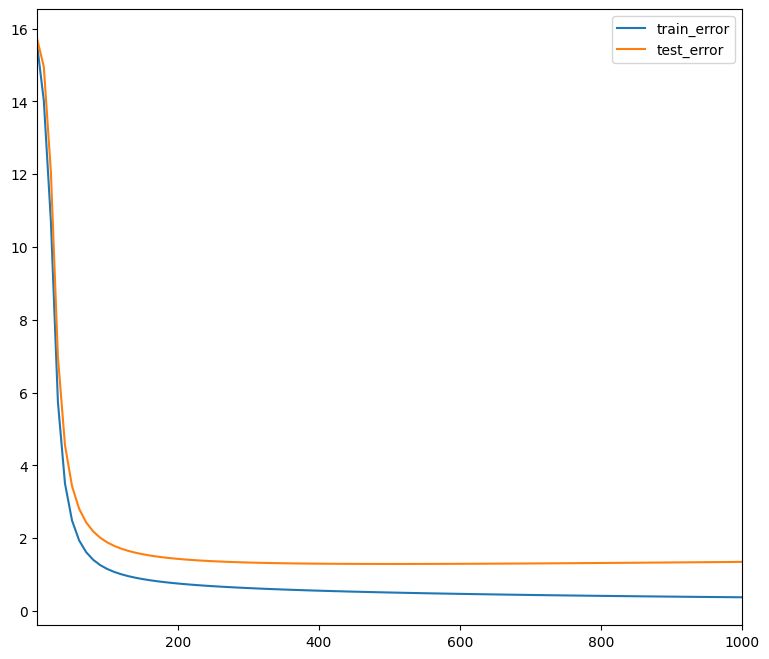

In [25]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

### Menghitung Skor Kemiripan

In [26]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

### Inference dengan Model Collaborative Filtering

In [27]:
def user_recommendations(model, measure=DOT, exclude_rated=True, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][942], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # Menghapus film yang sudah diberikan rating oleh user.
      rated_movies = ratings[ratings.user_id == "942"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [28]:
USER_RATINGS = True
user_recommendations(model, measure=COSINE, k=5)
user_recommendations(model, measure=DOT, k=5)

,cosine score,movie_id,titles,genres
638,0.712,638,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
1056,0.682,1056,"Pallbearer, The (1996)",Comedy
197,0.682,197,Nikita (La Femme Nikita) (1990),Thriller
730,0.672,730,"Corrina, Corrina (1994)",Comedy-Drama-Romance
44,0.648,44,Eat Drink Man Woman (1994),Comedy-Drama


,dot score,movie_id,titles,genres
886,7.052,886,Eve's Bayou (1997),Drama
1213,6.886,1213,In the Realm of the Senses (Ai no corrida) (1976),Drama
652,6.847,652,Touch of Evil (1958),Crime-Film-Noir-Thriller
638,6.547,638,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
1168,6.447,1168,Fresh (1994),Drama


### Fungsi untuk Rekomendasi Film berdasarkan Genre Film yg Telah Ditonton

In [29]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Mencari film berdasarkan judul yang dimasukkan.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [30]:
movie_neighbors(model, "Star Wars", DOT)
movie_neighbors(model, "Star Wars", COSINE)

Nearest neighbors of : Star Wars (1977).


,dot score,titles,genres
49,7.895,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
173,7.229,Raiders of the Lost Ark (1981),Action-Adventure
171,7.177,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
180,6.957,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
21,6.481,Braveheart (1995),Action-Drama-War
312,6.428,Titanic (1997),Action-Drama-Romance


Nearest neighbors of : Star Wars (1977).


,cosine score,titles,genres
49,1.000,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
171,0.950,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
180,0.949,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
173,0.925,Raiders of the Lost Ark (1981),Action-Adventure
209,0.868,Indiana Jones and the Last Crusade (1989),Action-Adventure
193,0.860,"Sting, The (1973)",Comedy-Crime
